In [1]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen
from IPython.display import Image as dispImg
import scipy.io
import numpy as np
import pandas
import tqdm
import fire
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from art.classifiers import PyTorchClassifier
import cornet
from art.attacks import BoundaryAttack
from art.attacks import HopSkipJump
from imgaug import augmenters as iaa
import imgaug as ia
#attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
from art.attacks import FastGradientMethod
from art.attacks import ElasticNet

from PIL import Image
Image.warnings.simplefilter('ignore')

ia.seed(1)
np.random.seed(0)
torch.manual_seed(0)

mean = torch.tensor([0.44, 0.44, 0.44], dtype=torch.float32)
std = torch.tensor([0.225, 0.225, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.44, 0.44, 0.44],
                                             std=[0.225, 0.225, 0.225])
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize
            ])
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def get_model(model_size='z', cuda=False):
    map_location = 'cpu' if not cuda else None
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    if cuda:
        model = model.cuda()
        return model
    model.cpu()
    return model.module

sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), deterministic=True)


                # Same as sharpen, but for an embossing effect.
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0), deterministic=True)


Load data

In [2]:
labels = pickle.load(open("labels.pkl", "rb" ))
y_val = np.load("D:\\imagenet2012\\y_val.npy")
print(f"{y_val.shape[0]} validation labels loaded")
data_path = 'D:\\imagenet2012\\val'
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(f"{len(fnames)} files found");

50000 validation labels loaded
50000 files found


In [3]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [4]:
def get_image_by_class(image_class):
    return Image.open(fnames[np.argsort((y_val == image_class))[-1]]).convert('RGB')

In [5]:
def plot_augmented(original_image, adv_image):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axes[0, 0].imshow(to_grayscale(original_image))
    axes[0, 1].imshow(to_grayscale(adv_image))
    axes[1, 0].imshow(to_grayscale(sharpen.augment_image(original_image)))
    axes[1, 1].imshow(to_grayscale(sharpen.augment_image(adv_image)))
    axes[2, 0].imshow(to_grayscale(emboss.augment_image(original_image)))
    axes[2, 1].imshow(to_grayscale(emboss.augment_image(adv_image)))
    plt.show()

In [14]:
def perform_attack(im, model_size, target_class=None, targeted=False, confidence=0.0, params={}):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    attack = ElasticNet(classifier=classifier, confidence=confidence, targeted=targeted, **params)
    
    x = transform(im).unsqueeze(0).numpy()
    
    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    top_5 = np.flip(np.argsort(pred)[-5:])
    print('\nOriginal image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {pred[t]}')
    print('\nGenerating adversarial example')
    x_adv = attack.generate(x=transform(im).unsqueeze(0).numpy(), y=np.array([target_class]) if target_class is not None else None)
    print('L2: ' + str(np.linalg.norm(np.reshape(x_adv[0] - x[0], [-1]))))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    axes[0].imshow(original_image)
    axes[1].imshow(pert_image)
    axes[2].imshow(adv_image)
    
    adv_pred = classifier.predict(x_adv)[0]
    adv_pred = np.exp(adv_pred)/sum(np.exp(adv_pred))
    top_5 = np.flip(np.argsort(adv_pred)[-5:])
    print('\nAdversarial image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {adv_pred[t]}')
    
    plt.show()

In [7]:
i=39218
print(labels[y_val[i]])
#target 39206

magpie


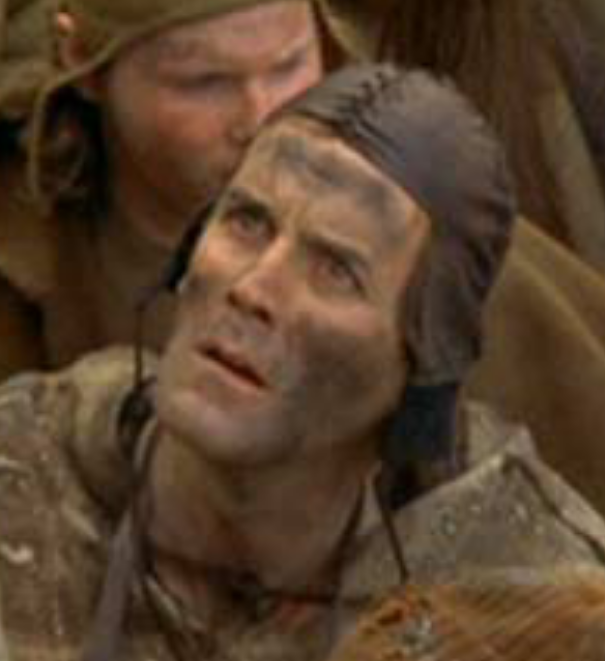

In [8]:
#im = Image.open(fnames[i]).convert('RGB')
#im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
im = Image.open("D:\\imagenet2012\john_cleese.png").convert('RGB')
#im = Image.open(fnames[np.argsort((y_val == 26))[-3]]).convert('RGB')
im

using model type: z

Original image predictions:
gyromitra (993): 0.12951360642910004
hartebeest (351): 0.10302609950304031
bloodhound, sleuthhound (163): 0.07946956157684326
Arabian camel, dromedary, Camelus dromedarius (354): 0.07580377906560898
potter's wheel (739): 0.035216543823480606

Generating adversarial example
L2: 47.59399

Adversarial image predictions:
consomme (925): 0.4723527729511261
hot pot, hotpot (926): 0.14550092816352844
soup bowl (809): 0.04626583680510521
gyromitra (993): 0.03760754317045212
plate (923): 0.03070044331252575


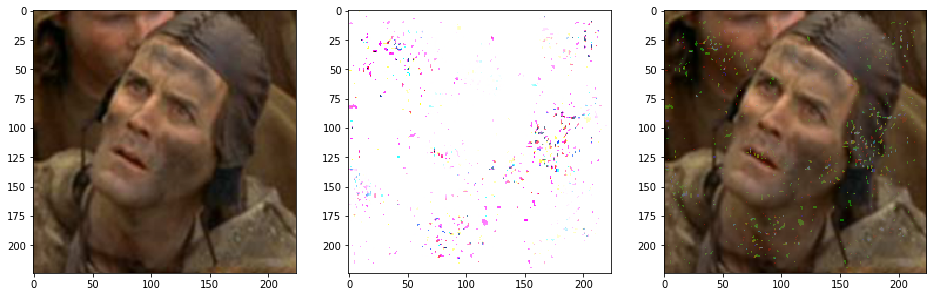

In [9]:
perform_attack(im, 'z')

using model type: z

Original image predictions:
gyromitra (993): 0.12951360642910004
hartebeest (351): 0.10302609950304031
bloodhound, sleuthhound (163): 0.07946956157684326
Arabian camel, dromedary, Camelus dromedarius (354): 0.07580377906560898
potter's wheel (739): 0.035216543823480606

Generating adversarial example
L2: 406.751

Adversarial image predictions:
common newt, Triturus vulgaris (26): 0.06153787672519684
crayfish, crawfish, crawdad, crawdaddy (124): 0.05785520747303963
quail (85): 0.05725555121898651
water snake (58): 0.05668037384748459
agama (42): 0.050856657326221466


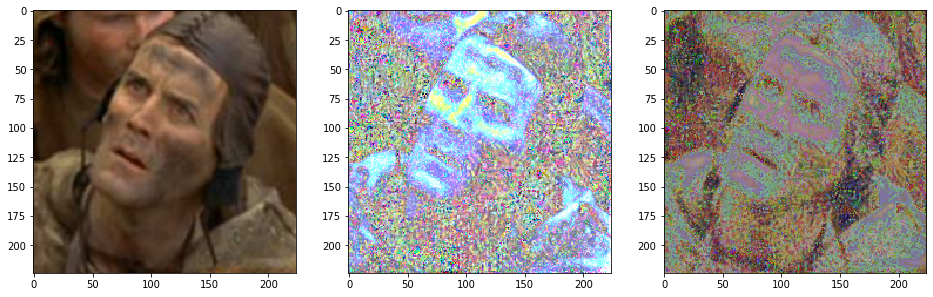

In [15]:
target_class=26 #lets turn him into a newt
perform_attack(im, 'z', target_class, True, 0.5, params={'max_iter':500})

using model type: s

Original image predictions:
tobacco shop, tobacconist shop, tobacconist (860): 0.06681566685438156
military uniform (652): 0.06391838937997818
plastic bag (728): 0.03656125068664551
panpipe, pandean pipe, syrinx (699): 0.03420693054795265
academic gown, academic robe, judge's robe (400): 0.03127473220229149

Generating adversarial example
L2: 253.89198

Adversarial image predictions:
common newt, Triturus vulgaris (26): 0.2143058478832245
eel (390): 0.07126910239458084
eft (27): 0.06562834978103638
banded gecko (38): 0.06386258453130722
alligator lizard (44): 0.05862422659993172


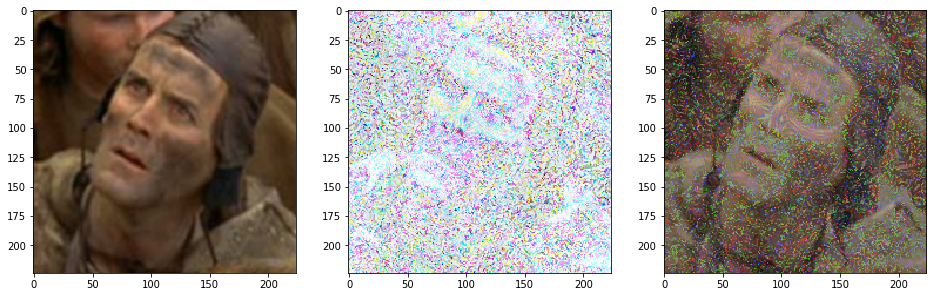

In [16]:
perform_attack(im, 's', target_class, True)

using model type: z

Original image predictions:
junco, snowbird (13): 0.8208329081535339
hornbill (93): 0.09115017205476761
bulbul (16): 0.07561135292053223
magpie (18): 0.002464961027726531
chickadee (19): 0.0017612366937100887

Generating adversarial example
L2: 138.94931

Adversarial image predictions:
jigsaw puzzle (611): 0.3252522647380829
junco, snowbird (13): 0.07487796247005463
chainlink fence (489): 0.06759094446897507
handkerchief, hankie, hanky, hankey (591): 0.04279975965619087
pillow (721): 0.03440254554152489


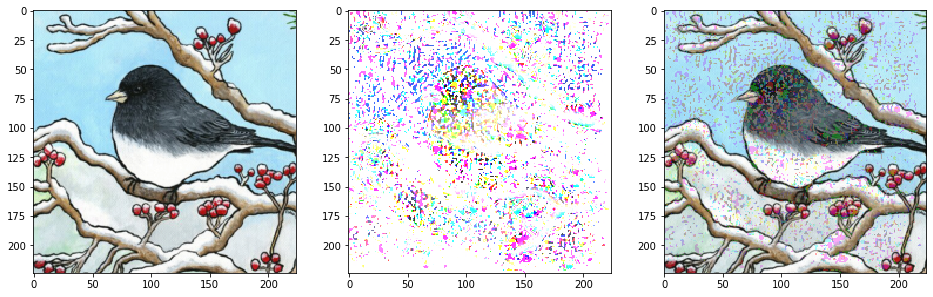

In [17]:
im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
perform_attack(im, 'z')

using model type: z

Original image predictions:
magpie (18): 0.9807124137878418
junco, snowbird (13): 0.008485633879899979
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.006327349226921797
drake (97): 0.002436782931908965
coucal (91): 0.0003534578427206725

Generating adversarial example
L2: 38.79706

Adversarial image predictions:
junco, snowbird (13): 0.621090292930603
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.36349278688430786
European gallinule, Porphyrio porphyrio (136): 0.004757111892104149
ruffed grouse, partridge, Bonasa umbellus (82): 0.002581158420071006
drake (97): 0.002308604307472706


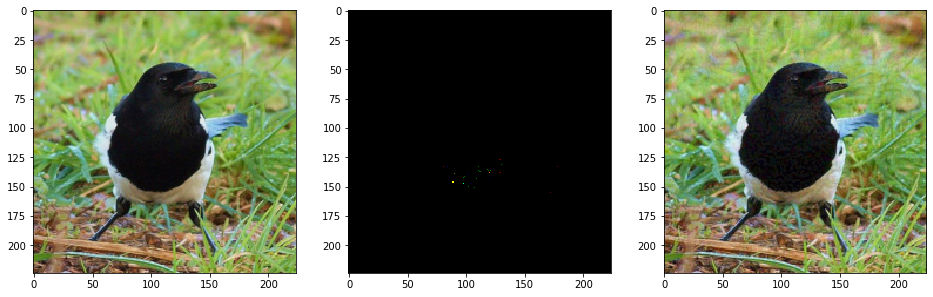

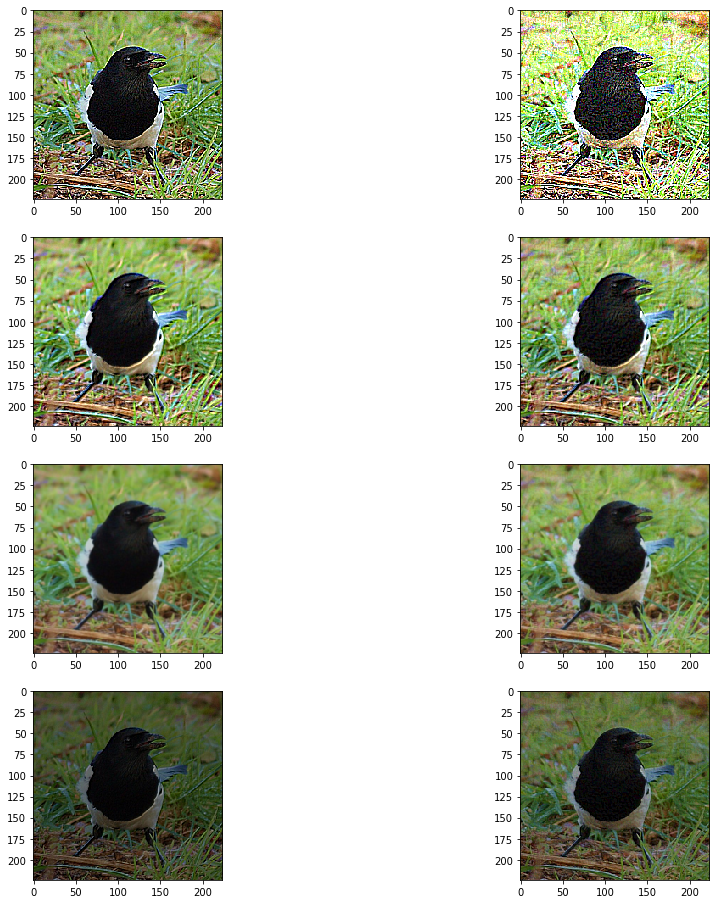

In [11]:
im = Image.open(fnames[39218]).convert('RGB')
perform_attack(im, 'z')

using model type: z

Original image predictions:
junco, snowbird (13): 0.8208329081535339
hornbill (93): 0.09115017205476761
bulbul (16): 0.07561135292053223
magpie (18): 0.002464961027726531
chickadee (19): 0.0017612366937100887

Generating adversarial example
L2: 352.56052

Adversarial image predictions:
street sign (919): 0.03096502460539341
sundial (835): 0.01970626227557659
birdhouse (448): 0.01843022182583809
jigsaw puzzle (611): 0.017912758514285088
mosquito net (669): 0.017639638856053352


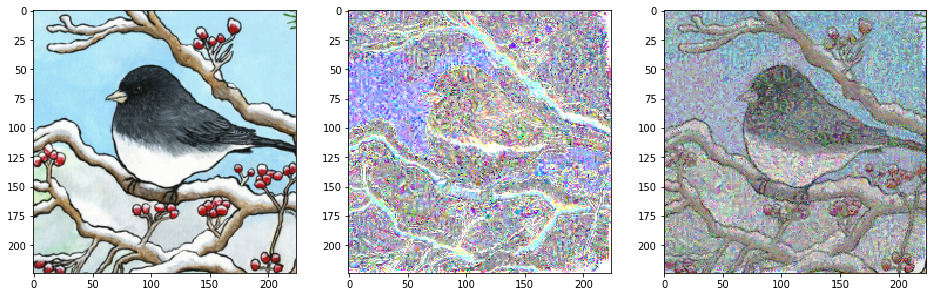

In [20]:
target_class = 919 #street sign
perform_attack(im, 'z', target_class, True)

using model type: z

Original image predictions:
junco, snowbird (13): 0.8208329081535339
hornbill (93): 0.09115017205476761
bulbul (16): 0.07561135292053223
magpie (18): 0.002464961027726531
chickadee (19): 0.0017612366937100887

Generating adversarial example
L2: 300.26764

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.2662131190299988
magpie (18): 0.09071388840675354
coucal (91): 0.05564771965146065
vulture (23): 0.04831869900226593
ruffed grouse, partridge, Bonasa umbellus (82): 0.04382685571908951


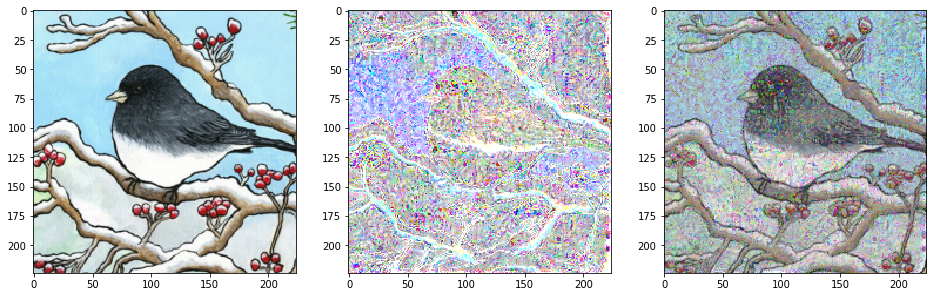

In [21]:
target_class = 24 #owl
perform_attack(im, 'z', target_class, True)

using model type: z

Original image predictions:
junco, snowbird (13): 0.8208329081535339
hornbill (93): 0.09115017205476761
bulbul (16): 0.07561135292053223
magpie (18): 0.002464961027726531
chickadee (19): 0.0017612366937100887

Generating adversarial example
L2: 300.26764

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.26621153950691223
magpie (18): 0.09071819484233856
coucal (91): 0.05564924329519272
vulture (23): 0.04831928387284279
ruffed grouse, partridge, Bonasa umbellus (82): 0.04382652789354324


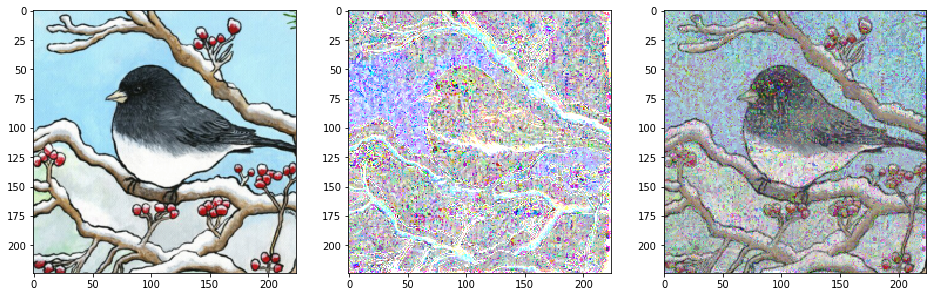

In [22]:
target_class = 24 #owl
im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
perform_attack(im, 'z', target_class, True)

using model type: s

Original image predictions:
junco, snowbird (13): 0.8199988603591919
prayer rug, prayer mat (741): 0.014861010946333408
handkerchief, hankie, hanky, hankey (591): 0.012516302056610584
robin, American robin, Turdus migratorius (15): 0.009601126424968243
tray (868): 0.008169511333107948

Generating adversarial example
L2: 38.797894

Adversarial image predictions:
handkerchief, hankie, hanky, hankey (591): 0.2238214910030365
tray (868): 0.1530425101518631
prayer rug, prayer mat (741): 0.0818370133638382
jigsaw puzzle (611): 0.049866750836372375
pillow (721): 0.046641755849123


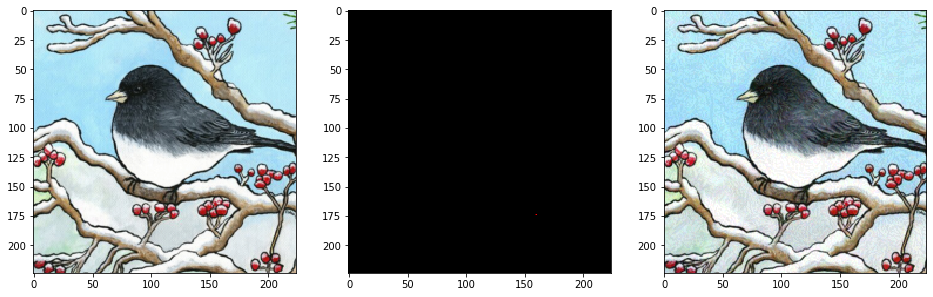

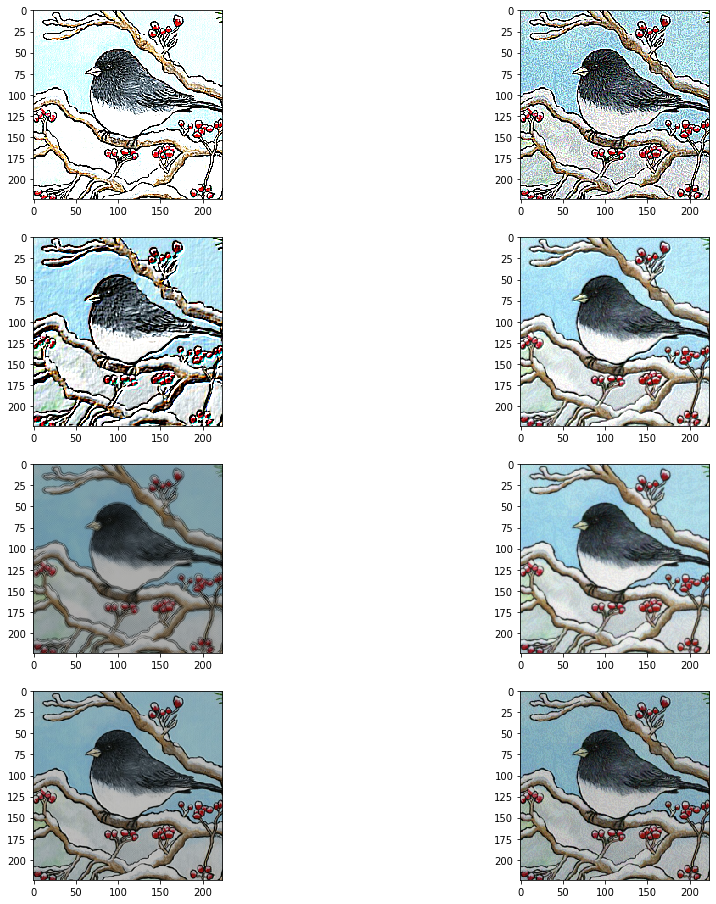

In [21]:

perform_attack(im, 's')

using model type: s

Original image predictions:
junco, snowbird (13): 0.8199988603591919
prayer rug, prayer mat (741): 0.014861010946333408
handkerchief, hankie, hanky, hankey (591): 0.012516302056610584
robin, American robin, Turdus migratorius (15): 0.009601126424968243
tray (868): 0.008169511333107948

Generating adversarial example
L2: 315.38443

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.0702102780342102
starfish, sea star (327): 0.06305167078971863
sea urchin (328): 0.05041709914803505
coral reef (973): 0.04643376171588898
howler monkey, howler (379): 0.040908753871917725


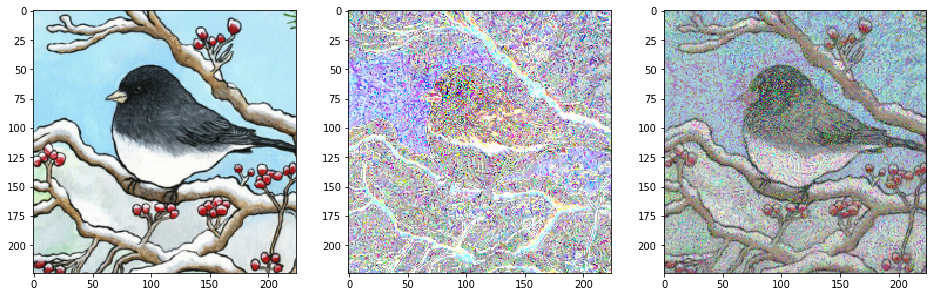

In [19]:
perform_attack(im, 's', target_class, True)

using model type: s

Original image predictions:
tobacco shop, tobacconist shop, tobacconist (860): 0.06681566685438156
military uniform (652): 0.06391838937997818
plastic bag (728): 0.03656125068664551
panpipe, pandean pipe, syrinx (699): 0.03420693054795265
academic gown, academic robe, judge's robe (400): 0.03127473220229149

Generating adversarial example
L2: 38.68324

Adversarial image predictions:
Chesapeake Bay retriever (209): 0.40689268708229065
vizsla, Hungarian pointer (211): 0.042698100209236145
clumber, clumber spaniel (216): 0.025501064956188202
Sussex spaniel (220): 0.023614777252078056
curly-coated retriever (206): 0.022585485130548477


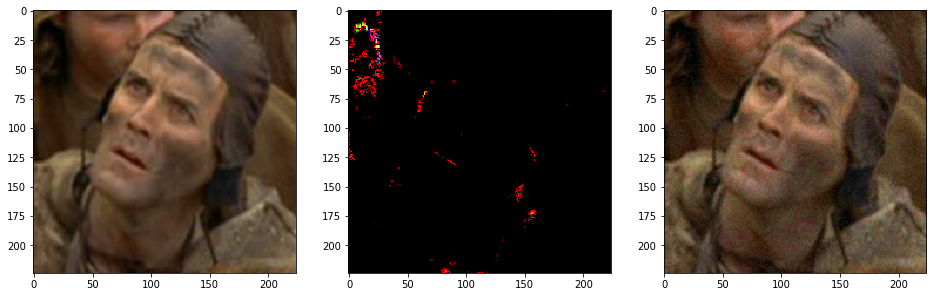

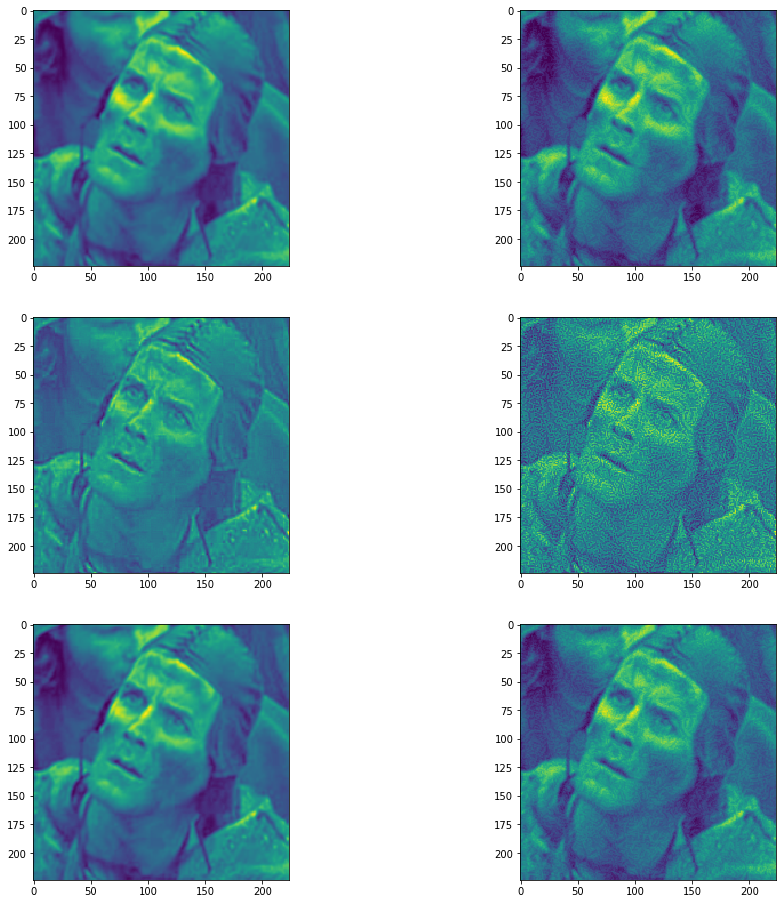

In [11]:
perform_attack(im, 's', eps=0.3)

using model type: z

Original image predictions:
sandal (774): 0.1541583389043808
running shoe (770): 0.10500852018594742
clog, geta, patten, sabot (502): 0.05704495310783386
buckle (464): 0.056612420827150345
hatchet (596): 0.036182377487421036

Generating adversarial example
L2: 321.07043

Adversarial image predictions:
junco, snowbird (13): 0.14947956800460815
African chameleon, Chamaeleo chamaeleon (47): 0.097361259162426
jigsaw puzzle (611): 0.06684327125549316
coucal (91): 0.04370594024658203
magpie (18): 0.027181370183825493


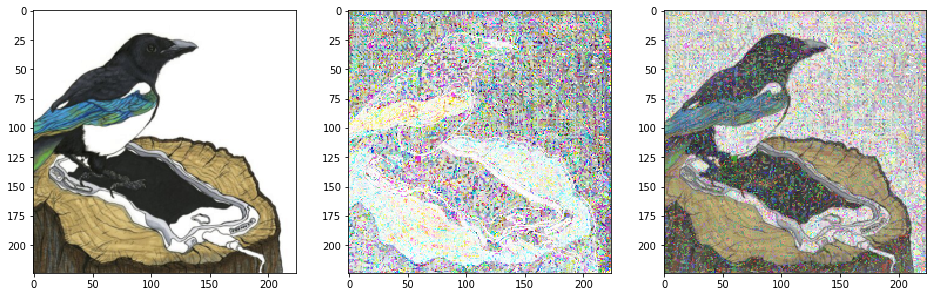

In [23]:
im = Image.open("D:\\imagenet2012\\magpie.jpg").convert('RGB')
perform_attack(im, 'z', 13, True)

using model type: s

Original image predictions:
magpie (18): 0.807257354259491
jay (17): 0.09320010989904404
black grouse (80): 0.010717383585870266
stole (824): 0.005895387381315231
water ouzel, dipper (20): 0.0035025232937186956

Generating adversarial example
L2: 328.31274

Adversarial image predictions:
junco, snowbird (13): 0.26569220423698425
hummingbird (94): 0.052066609263420105
jay (17): 0.039993103593587875
chickadee (19): 0.03503939509391785
bulbul (16): 0.033223990350961685


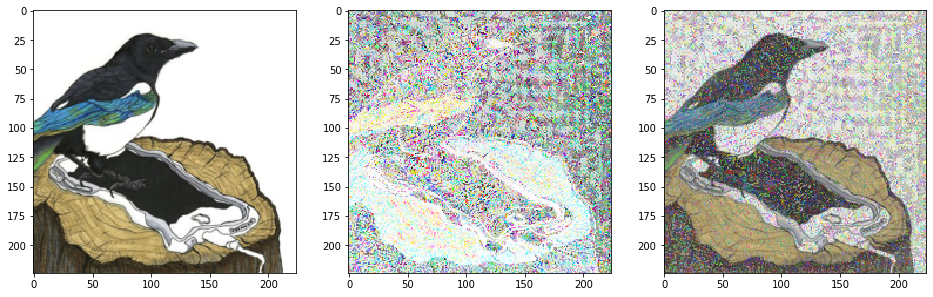

In [24]:
perform_attack(im, 's', 13, True)

<img src="https://upload.wikimedia.org/wikipedia/commons/5/5d/Seurat-La_Parade_detail.jpg"></img>

pointillism